In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix
import seaborn as sns
from google.colab import drive
import torch.nn.functional as F


drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive/Project271B

/content/drive/.shortcut-targets-by-id/1Nr0kdWFr2lwIr68GZsixdoEXZU3DUzVg/Project271B


In [ ]:
Data = pd.read_csv("OS_data_2")
Data.head()

,Unnamed: 0,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,TenYearCHD
0,0,0,38,2.0,0,0.0,0.0,0,0,0,169.0,115.0,60.0,26.87,65.0,0
1,1,1,40,2.0,1,30.0,0.0,0,1,0,282.0,130.0,80.0,23.90,66.0,0
2,2,1,49,2.0,0,0.0,0.0,0,1,0,271.0,140.0,108.0,27.66,82.0,0
3,3,1,38,1.0,1,9.0,0.0,0,0,0,305.0,114.0,80.0,28.61,75.0,0
4,4,0,63,1.0,1,10.0,1.0,0,1,0,213.0,182.0,92.0,26.87,52.0,0


In [ ]:
y_train = Data['TenYearCHD']
X_train = Data.drop('TenYearCHD', axis=1)


In [ ]:
Data_test = pd.read_csv("OS_test_2")
Data_test.head()

,Unnamed: 0,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,TenYearCHD
0,2077,0,59,1.0,0,0.0,0.0,0,1,0,220.0,145.0,86.0,25.90,90.0,0
1,1623,1,46,1.0,1,5.0,0.0,0,0,0,221.0,125.0,88.0,24.81,72.0,0
2,3580,0,65,1.0,1,3.0,0.0,0,0,0,217.0,169.0,111.0,32.54,65.0,0
3,3837,0,42,3.0,0,0.0,0.0,0,0,0,215.0,111.0,72.0,25.38,77.0,0
4,575,1,43,1.0,1,43.0,0.0,0,0,0,215.0,122.0,76.0,26.84,85.0,0


In [ ]:
y_test = Data_test['TenYearCHD']
X_test = Data_test.drop('TenYearCHD', axis=1)


In [ ]:

#X_train = pd.read_csv("xtrain_dropped.csv")
#X_test = pd.read_csv("xest_dropped.csv")
#y_train = pd.read_csv("ytrain_dropped.csv")
#y_test = pd.read_csv("ytest_dropped.csv")

X_train = X_train.loc[:, ~X_train.columns.str.contains('^Unnamed')]
X_test = X_test.loc[:, ~X_test.columns.str.contains('^Unnamed')]
#y_train = y_train.loc[:, ~y_train.columns.str.contains('^Unnamed')]
#y_test = y_test.loc[:, ~y_test.columns.str.contains('^Unnamed')]
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
#y_train.reshape((5756,1))
#y_test.reshape((798,1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5756, 14) (599, 14) (5756, 1) (599, 1)


In [ ]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train.values)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test.values)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
class NAM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NAM, self).__init__()
        
        # Define the linear combinations of networks
        self.networks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, output_size)
            ) for i in range(input_size)
        ])
        
    def forward(self, x):
        # Calculate the output for each network and sum them up
        outputs = [self.networks[i](x[:,i].unsqueeze(1)) for i in range(x.size(1))]
        y = torch.sum(torch.stack(outputs, dim=0), dim=0)
        y = F.sigmoid(y)
        return y

In [ ]:
input_size = 15
hidden_size = 20
output_size = 1
model = NAM(input_size, hidden_size, output_size)

learning_rate = 0.01
epochs = 500
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.BCELoss()

# Generate some random input data
x = torch.randn(32, input_size)

# Calculate the output

# print(X_train.shape) 
y = model(X_train)

# y = model(x)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
y.shape

torch.Size([5756, 1])

In [ ]:
for epoch in range(epochs+1):
  optimizer.zero_grad()
  y_pred = model(X_train)
  loss = criterion(y_pred, y_train)
  loss.backward()
  optimizer.step()
  
  if epoch % 15 == 0:
      print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.7570
Epoch 15, Loss: 0.6061
Epoch 30, Loss: 0.5864
Epoch 45, Loss: 0.5544
Epoch 60, Loss: 0.5077
Epoch 75, Loss: 0.4685
Epoch 90, Loss: 0.4408
Epoch 105, Loss: 0.4143
Epoch 120, Loss: 0.4126
Epoch 135, Loss: 0.4017
Epoch 150, Loss: 0.3914
Epoch 165, Loss: 0.3912
Epoch 180, Loss: 0.4245
Epoch 195, Loss: 0.4186
Epoch 210, Loss: 0.3847
Epoch 225, Loss: 0.3772
Epoch 240, Loss: 0.3750
Epoch 255, Loss: 0.3746
Epoch 270, Loss: 0.3872
Epoch 285, Loss: 0.3789
Epoch 300, Loss: 0.3712
Epoch 315, Loss: 0.3653
Epoch 330, Loss: 0.3791
Epoch 345, Loss: 0.3690
Epoch 360, Loss: 0.3645
Epoch 375, Loss: 0.3728
Epoch 390, Loss: 0.3752
Epoch 405, Loss: 0.3631
Epoch 420, Loss: 0.3598
Epoch 435, Loss: 0.3570
Epoch 450, Loss: 0.3562
Epoch 465, Loss: 0.3559
Epoch 480, Loss: 0.3796
Epoch 495, Loss: 0.3865


AUC score: 0.82
F1 score: 0.82
Accuracy: 0.5000
Legitimate Transactions Detected (True Negatives):  2338
Legitimate Transactions Incorrectly Detected (False Positives):  540
Fraudulent Transactions Missed (False Negatives):  497
Fraudulent Transactions Detected (True Positives):  2381
Total Fraudulent Transactions:  2878


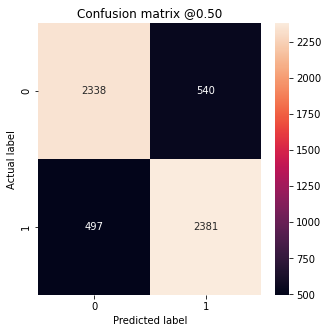

In [ ]:
# Evaluate the train model
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = torch.round(y_pred)

    accuracy = (y_pred == y_train.unsqueeze(1)).float().mean()
    auc = roc_auc_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    print("AUC score: {:.2f}".format(auc))
    print("F1 score: {:.2f}".format(f1))
    print(f"Accuracy: {accuracy.item():.4f}")

    plot_cm(y_train, y_pred)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


AUC score: 0.60
F1 score: 0.31
Accuracy: 0.6823
Legitimate Transactions Detected (True Negatives):  403
Legitimate Transactions Incorrectly Detected (False Positives):  111
Fraudulent Transactions Missed (False Negatives):  49
Fraudulent Transactions Detected (True Positives):  36
Total Fraudulent Transactions:  85


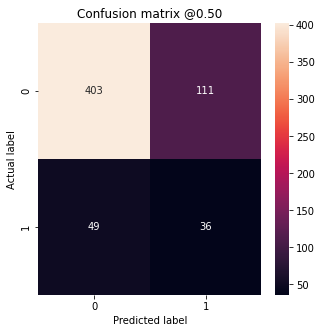

In [ ]:
# Evaluate the test model
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = torch.round(y_pred)
    accuracy = (y_pred == y_test.unsqueeze(1)).float().mean()

    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("AUC score: {:.2f}".format(auc))
    print("F1 score: {:.2f}".format(f1))
    print(f"Accuracy: {accuracy.item():.4f}")

    plot_cm(y_test, y_pred)
